In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tifffile as tf

from skimage.measure import label
from skimage import util as u
from skimage.morphology import disk, ball, binary_opening, binary_erosion
from skimage.filters import threshold_otsu, threshold_multiotsu, threshold_minimum
import skimage.filters as filters
import skimage.exposure as exposure
from skimage.segmentation import clear_border

from scipy.ndimage import binary_fill_holes

In [2]:
def get_unimodal_threshold(input_image):
    """Determines optimal unimodal threshold

    https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf
    https://www.mathworks.com/matlabcentral/fileexchange/45443-rosin-thresholding

    :param np.array input_image: generate mask for this image
    :return float best_threshold: optimal lower threshold for the foreground
     hist
    """

    hist_counts, bin_edges = np.histogram(
        input_image,
        bins=256,
        range=(input_image.min(), np.percentile(input_image, 99.5))
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # assuming that background has the max count
    max_idx = np.argmax(hist_counts)
    int_with_max_count = bin_centers[max_idx]
    p1 = [int_with_max_count, hist_counts[max_idx]]

    # find last non-empty bin
    pos_counts_idx = np.where(hist_counts > 0)[0]
    last_binedge = pos_counts_idx[-1]
    p2 = [bin_centers[last_binedge], hist_counts[last_binedge]]

    best_threshold = -np.inf
    max_dist = -np.inf
    for idx in range(max_idx, last_binedge, 1):
        x0 = bin_centers[idx]
        y0 = hist_counts[idx]
        a = [p1[0] - p2[0], p1[1] - p2[1]]
        b = [x0 - p2[0], y0 - p2[1]]
        cross_ab = a[0] * b[1] - b[0] * a[1]
        per_dist = np.linalg.norm(cross_ab) / np.linalg.norm(a)
        if per_dist > max_dist:
            best_threshold = x0
            max_dist = per_dist
    assert best_threshold > -np.inf, 'Error in unimodal thresholding'
    return best_threshold


def create_unimodal_mask(input_image, str_elem_size=3):
    """Create a mask with unimodal thresholding and morphological operations

    unimodal thresholding seems to oversegment, erode it by a fraction

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if np.min(input_image) == np.max(input_image):
        thr = np.unique(input_image)
    else:
        thr = get_unimodal_threshold(input_image)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_erosion(thr_image, str_elem)
    return mask


def create_otsu_mask(input_image, scale=1):
    """Create a binary mask using morphological operations

    Opening removes small objects in the foreground.

    :param np.array input_image: generate masks from this image
    :param float scale: Scale the threshold
    :return: mask of input_image, np.array
    """
    if np.min(input_image) == np.max(input_image):
        return np.ones(input_image.shape)
    else:
        thr = threshold_otsu(input_image, nbins=512)
    return input_image > (scale * thr)


def create_multiotsu_mask(input_image, n_class, fg_class, str_elem_size=3):
    """Create a binary mask using morphological operations

    Opening removes small objects in the foreground.

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """
    if np.min(input_image) == np.max(input_image):
        return np.ones(input_image.shape)
    else:
        thr = threshold_multiotsu(input_image, classes=n_class, nbins=512)
        im_label = np.digitize(input_image, bins=thr)
        mask = im_label == fg_class

    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    mask = binary_opening(mask, str_elem)
    return mask


def get_largest_component(spot_segm):
    """
    Remove everything but the largest connected component from segmented image.

    :param np.array spot_segm: Binary segmented 2D image
    :return np.array largest_component: Largest connected component in image
    """
    labels = label(spot_segm)
    largest_component = labels.copy()
    if labels.max() > 0:
        largest_component = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1
    return largest_component.astype(labels.dtype)


def thresh_and_binarize(image,
                        method='rosin',
                        invert=True,
                        disk_size=10,
                        thr_percent=95,
                        get_lcc=False):
    """
    receives greyscale np.ndarray image
        inverts the intensities
        thresholds on the minimum peak
        converts the image into binary about that threshold

    :param np.ndarray image: 2D grayscale image
    :param str method: Trheshold type: 'bimodal', 'otsu', 'rosin' or 'bright_spots'
    :param bool invert: Invert image if spots are dark
    :param int disk_size: Structuring element disk size
    :param int thr_percent: Thresholding percentile
    :param bool get_lcc: Returns only the largest connected component
    :return: spots threshold_min on this image
    """
    image_ = image.copy()
    if invert:
        image_ = u.invert(image_)

    if method == 'bimodal':
        thresh = threshold_minimum(image_, nbins=512)
        spots = (image_ > thresh).astype(np.uint8)

    elif method == 'otsu':
        spots = create_otsu_mask(image_, scale=1)

    elif method == 'rosin':
        spots = create_unimodal_mask(image_, str_elem_size=3)

    elif method == 'bright_spots':
        spots = image_ > np.percentile(image_, thr_percent)
        str_elem = disk(disk_size)
        spots = binary_opening(spots, str_elem)
        spots = binary_fill_holes(spots, str_elem)
        spots = clear_border(spots)

    else:
        raise ModuleNotFoundError("not a supported method for thresh_and_binarize")

    if get_lcc:
        spots = get_largest_component(spots)

    return spots

In [3]:
projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# DiI stains any membrane, so even C5 site might include non-MG
# sample = "2020-01-28/DiI_Snaps_RAW/SM_GW22_2020_0129_1619_DiI_Snaps"
# site = "C5-Site_0"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_B2_1"
s = 0
site = f"B2-Site_{s}"

In [45]:
# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

In [60]:
# for DiI files
# fluor = sorted([file for file in os.listdir(target) if "RHO" in file])

# for mm2-gamma files (antibody stained)
# fluor = sorted([file for file in os.listdir(target) if "channel001" in file]) # channel001 = Iba1-488
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel001 = GFAP-488 (glial)

In [61]:
image = tf.imread(os.path.join(target, fluor[2]))

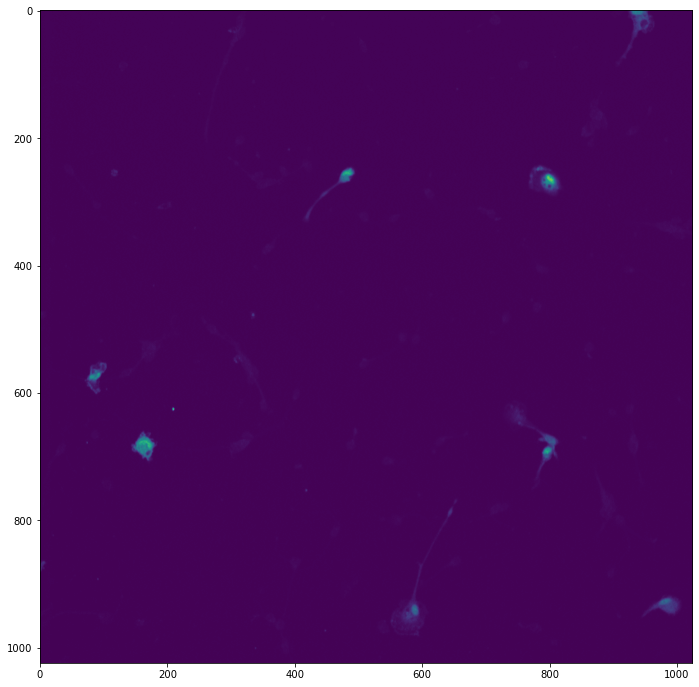

In [62]:
plt.figure(figsize=(12,12))
plt.imshow(image)

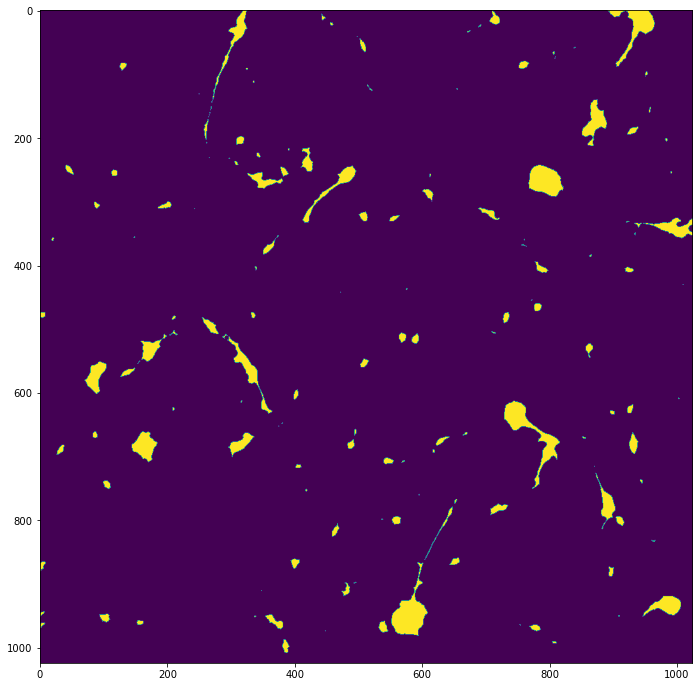

In [71]:
# explore segmentation parameters to use this fluorescent signal as morphology labels
image = exposure.adjust_gamma(image, 0.1)

th1 = thresh_and_binarize(image,
                          method='rosin',
                          invert=False,
                          disk_size=5,
                          thr_percent=95,
                          get_lcc=False)

plt.figure(figsize=(12,12))
plt.imshow(th1)
# tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/Composites/b2-site0_rosin.tif', th1)

'\nconclusion: fine structures are maintained as well as overall morphology.\n\n** probably the best approach **\n\n'

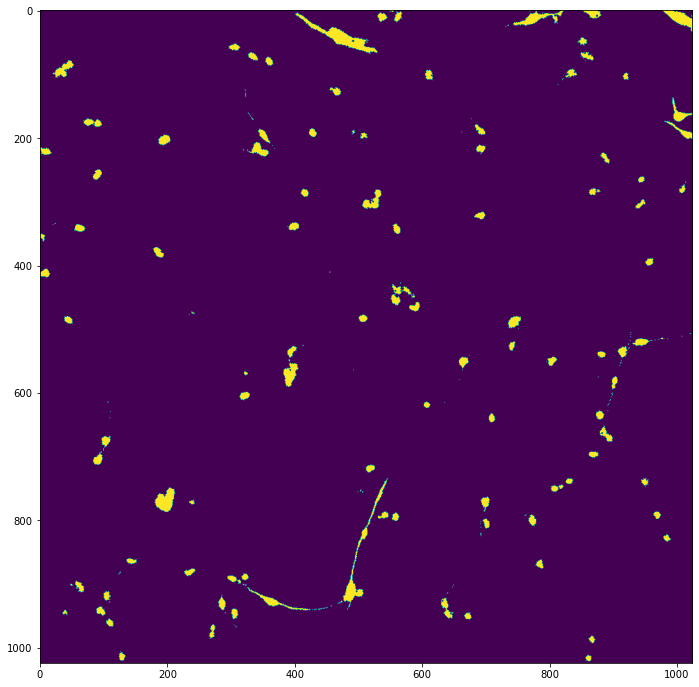

In [24]:
# rosin uses "create unimodal mask"
th1 = create_unimodal_mask(image, str_elem_size=1)

plt.figure(figsize=(12,12))
plt.imshow(th1)

"""
conclusion: fine structures are maintained as well as overall morphology.

** probably the best approach **

"""

'\nconclusion: leaves very fine elements.  This might not be useful\n'

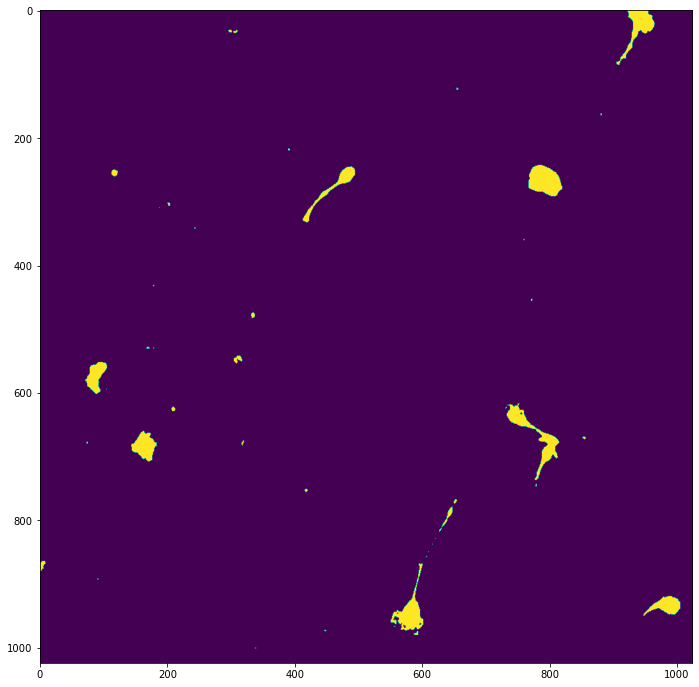

In [72]:
# Otsu
image = exposure.adjust_gamma(image, 0.1)

th1 = create_otsu_mask(image, scale=1)
# create_multiotsu_mask(input_image, n_class, fg_class, str_elem_size=3):

plt.figure(figsize=(12,12))
plt.imshow(th1)

tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/Composites/b2-site0_otsu.tif', th1)

"""
conclusion: leaves very fine elements.  This might not be useful
"""

'\nconclusion: the multiotsu function is very insensitive to any parameters other than n_class.\nnot useful unless we have more than one intensity thresholds\n'

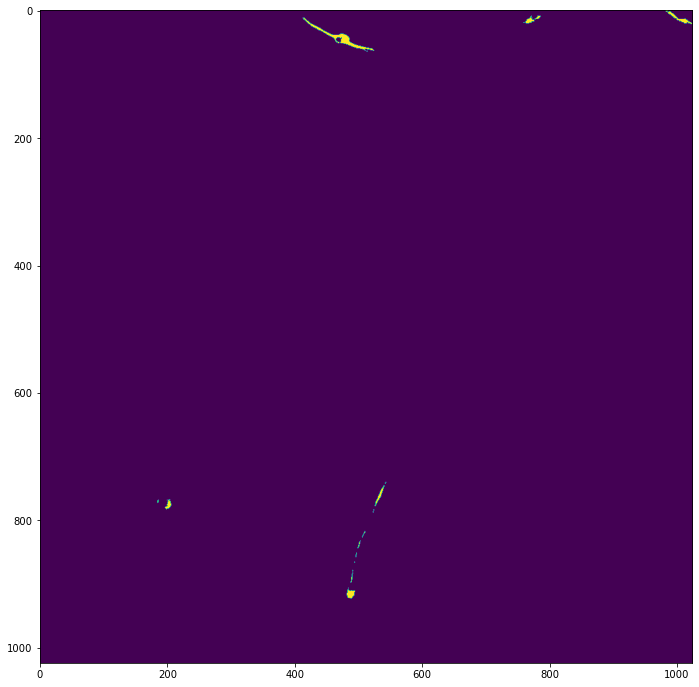

In [26]:
# Otsu
# create_multiotsu_mask(image, n_class, fg_class, str_elem_size=3):
create_multiotsu_mask(image, 2, 1, str_elem_size=5)

plt.figure(figsize=(12,12))
plt.imshow(th1)

"""
conclusion: the multiotsu function is very insensitive to any parameters other than n_class.
not useful unless we have more than one intensity thresholds
"""

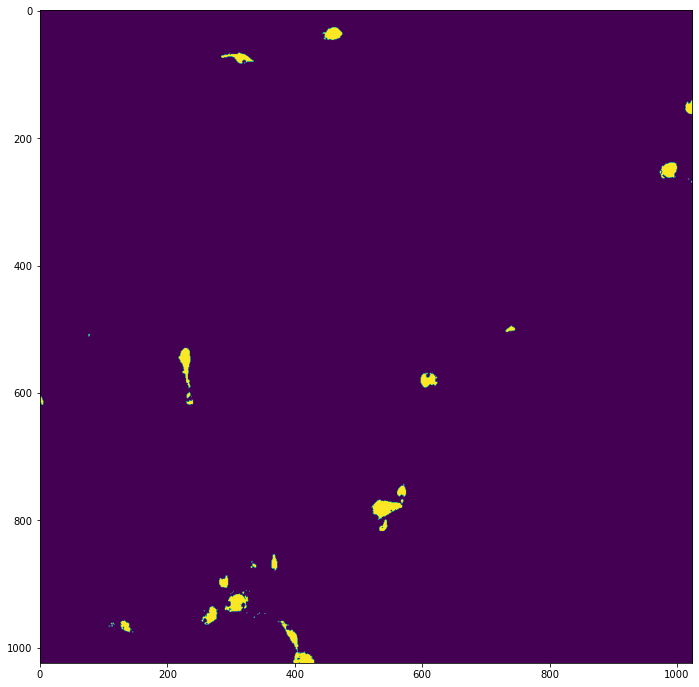

In [140]:
# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# DiI stains any membrane, so even C5 site might include non-MG
# sample = "2020-01-28/DiI_Snaps_RAW/SM_GW22_2020_0129_1619_DiI_Snaps"
# site = "C5-Site_0"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_B2_1"
s = 4
site = f"B2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel002 = Iba1-488

image = tf.imread(os.path.join(target, fluor[2]))

# rosin uses "create unimodal mask"
# mask = create_unimodal_mask(image, str_elem_size=1)

# multiotsu
# mask = create_multiotsu_mask(image, 3, 0, str_elem_size=2)
# fg_class = 0
# thr = threshold_multiotsu(image, classes=3, nbins=128)
# im_label = np.digitize(image, bins=thr)
# mask = im_label == fg_class

# single otsu
mask = create_otsu_mask(image)

# remove small objects in mask
# str_elem = disk(1)
# mask = binary_opening(mask, str_elem)

plt.figure(figsize=(12,12))
plt.imshow(mask)

out = '/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/target_binary'
tf.imsave(os.path.join(out, fluor[2]), mask)

/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1/C2-Site_0/img_channel002_position000_time000000000_z002.tif


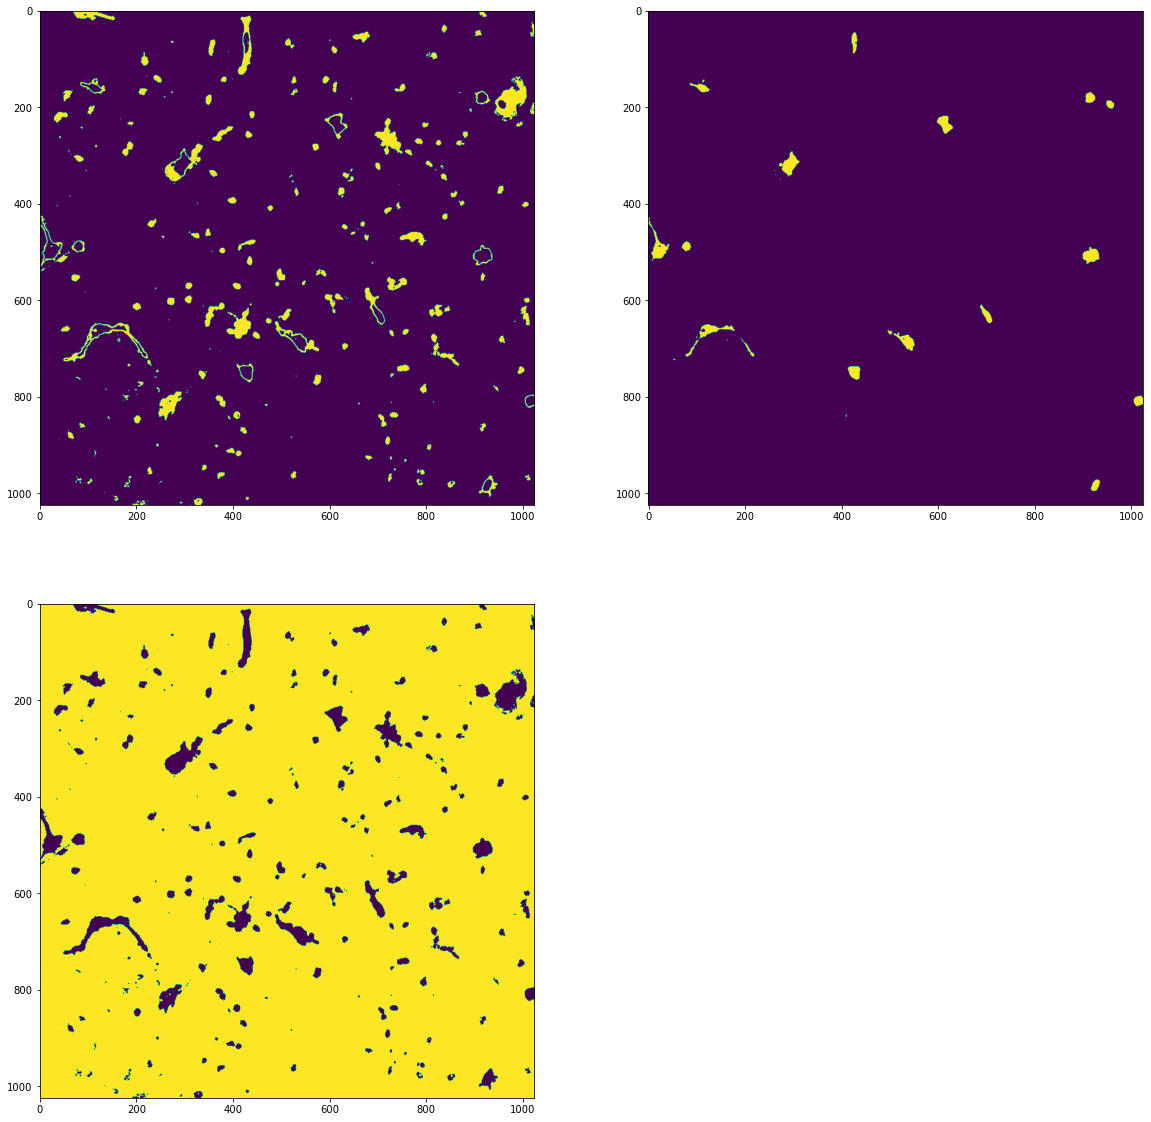

In [359]:
# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# DiI stains any membrane, so even C5 site might include non-MG
# sample = "2020-01-28/DiI_Snaps_RAW/SM_GW22_2020_0129_1619_DiI_Snaps"
# site = "C5-Site_0"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1"
s = 0
site = f"C2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel002 = Iba1-488
print(os.path.join(target, fluor[2]))

image = tf.imread(os.path.join(target, fluor[2]))

# ===== PRE FILTERS ========== #
image = exposure.adjust_gamma(image, 0.1)
image = filters.gaussian(image, sigma=1)
# image = filters.sobel(image)
# image = filters.laplace(image, ksize=3)
# thresh = threshold_minimum(image[image>500], nbins=512)
# image = (image > thresh).astype(np.uint8)


# ===== THRESHOLDS =========== #
# == ROSIN: "create unimodal mask"
# mask = create_unimodal_mask(image, str_elem_size=1)
# mask = create_multiotsu_mask(image, 3, 0)
# mask = thresh_and_binarize(image,
#                         method='bright_spots',
#                         invert=False,
#                         disk_size=1,
#                         thr_percent=95,
#                         get_lcc=False)

# == MULTI OTSU ==
thr = threshold_multiotsu(image, classes=3, nbins=512)
im_label = np.digitize(image, bins=thr)
mask0 = im_label == 0
mask1 = im_label == 1
mask2 = im_label == 2

# == SINGLE OTSU ==
# mask = create_otsu_mask(image)


# == CLEAN UP == 
# remove small objects in mask
# mask = filters.gaussian(mask, sigma=1.5)
# mask = create_unimodal_mask(mask)

# str_elem = disk(1)
# mask = binary_opening(mask, str_elem)
# mask = binary_fill_holes(mask, str_elem)
# mask = binary_erosion(mask, str_elem)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 3)
plt.imshow(mask0)
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)


# plt.figure(figsize=(12,12))
# plt.imshow(mask)

/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1/C2-Site_0/img_channel002_position000_time000000000_z000.tif
float64
bool


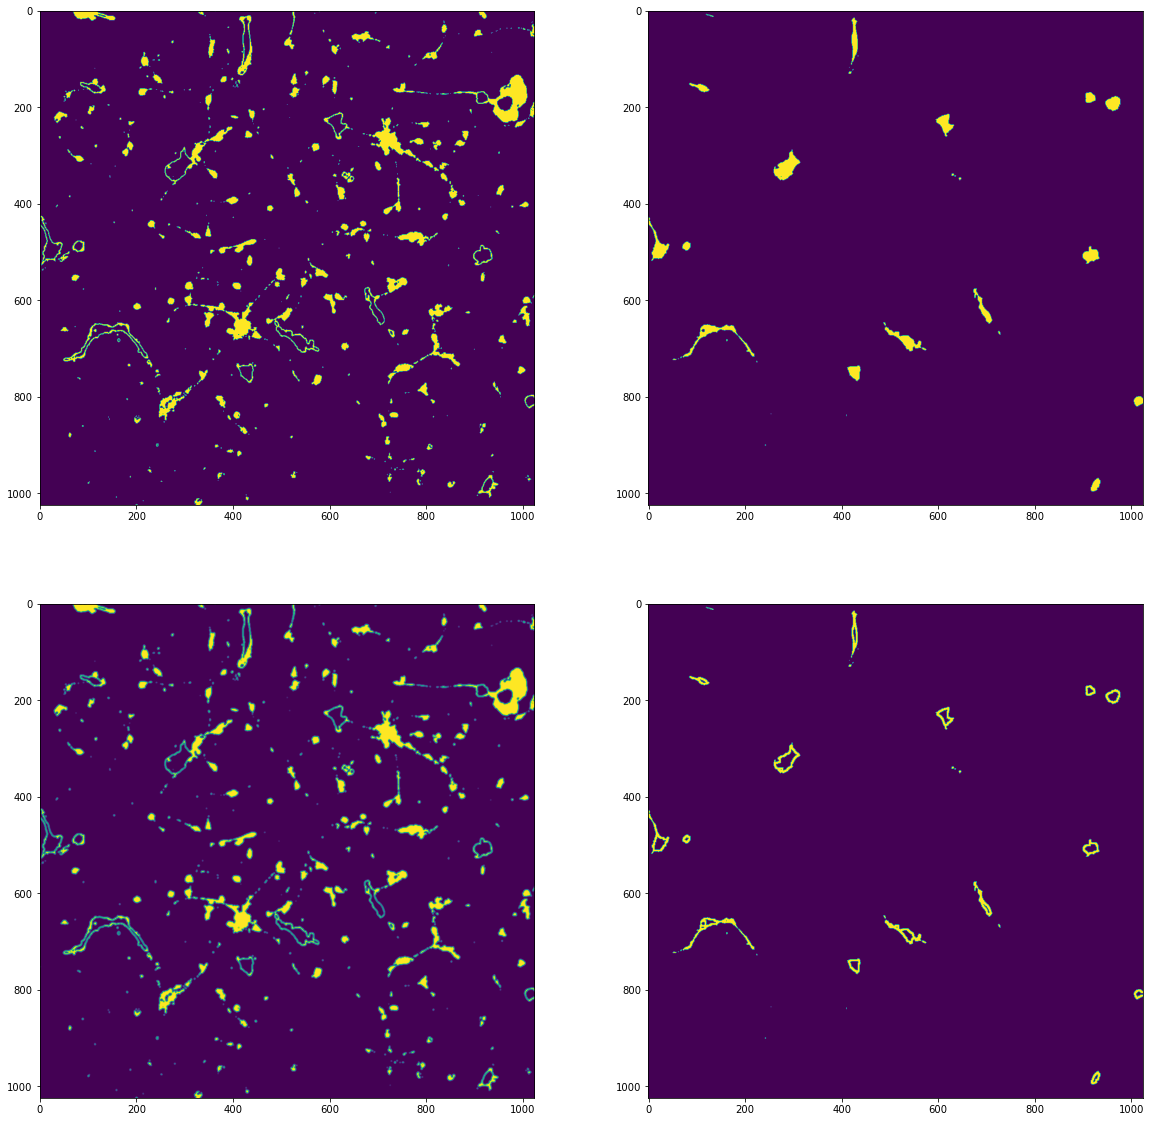

In [381]:
"""
Same as above cell but with experiments for post-multiotsu cleanup
- 
"""

# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# DiI stains any membrane, so even C5 site might include non-MG
# sample = "2020-01-28/DiI_Snaps_RAW/SM_GW22_2020_0129_1619_DiI_Snaps"
# site = "C5-Site_0"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1"
s = 0
site = f"C2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel002 = Iba1-488
print(os.path.join(target, fluor[0]))

image = tf.imread(os.path.join(target, fluor[0]))

# ===== PRE FILTERS ========== #
image = exposure.adjust_gamma(image, 0.1)
image = filters.gaussian(image, sigma=1)

# ===== THRESHOLDS =========== #
# == MULTI OTSU ==
thr = threshold_multiotsu(image, classes=3, nbins=512)
im_label = np.digitize(image, bins=thr)
mask0 = im_label == 0
mask1 = im_label == 1
mask2 = im_label == 2


# == CLEAN UP == 

# -- try to use two channels from the multi-otsu to create a consensus result --
blur_mask1 = filters.gaussian(mask1, sigma=1)
# blur_mask1[blur_mask1 > 0] = True
# str_elem = disk(5)
# blur_mask1 = filters.median(mask1, selem=str_elem)
# overlap = mask2 == blur_mask1
overlap = np.logical_and(blur_mask1, mask2)
print(blur_mask1.dtype)
print(mask2.dtype)

# from skimage.segmentation import join_segmentations
# overlap = join_segmentations(1*mask2, 1*blur_mask1)


# remove small objects in mask
# mask = filters.gaussian(mask, sigma=1.5)
# mask = create_unimodal_mask(mask)

# str_elem = disk(1)
# mask = binary_opening(mask, str_elem)
# mask = binary_fill_holes(mask, str_elem)
# mask = binary_erosion(mask, str_elem)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)
fig.add_subplot(2, 2, 3)
plt.imshow(blur_mask1)
fig.add_subplot(2, 2, 4)
plt.imshow(overlap)


# plt.figure(figsize=(12,12))
# plt.imshow(mask)

/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1/C2-Site_0/img_channel002_position000_time000000000_z000.tif


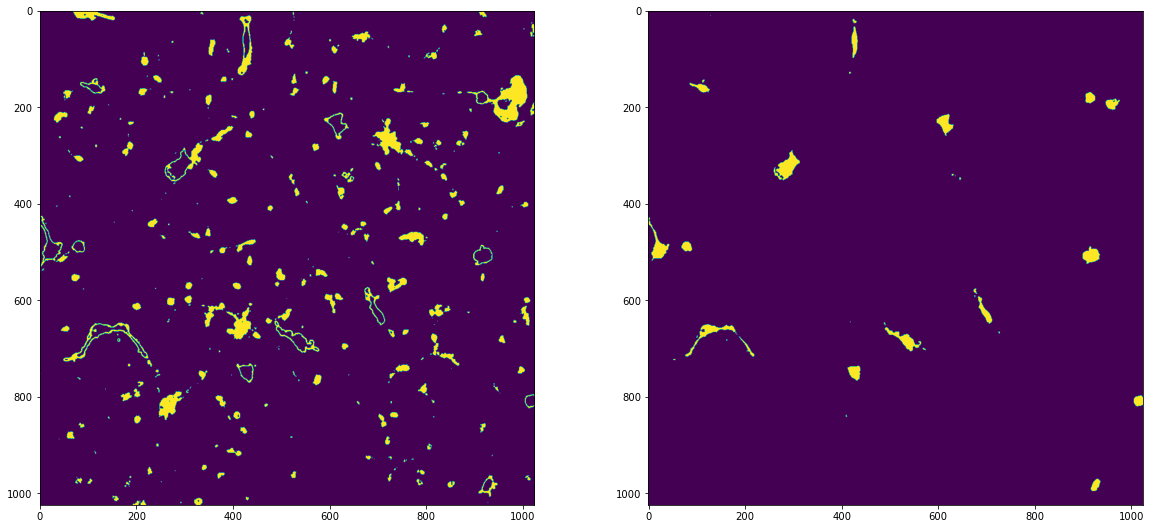

In [650]:
"""
method
1. take coordinates of mask channel 1 from multiotsu (which shows medium intensity segmentations, including edges of MG)
2. take coordinates of mask channel 2 from multiotsu
3. using measure.regionprop -- find those props in 1 that are most close to props in 2
4. combine the region props from the 1 and 2
"""

"""
Same as above cell but with experiments for post-multiotsu cleanup
- 
"""

# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# DiI stains any membrane, so even C5 site might include non-MG
# sample = "2020-01-28/DiI_Snaps_RAW/SM_GW22_2020_0129_1619_DiI_Snaps"
# site = "C5-Site_0"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1"
s = 0
site = f"C2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel002 = Iba1-488
print(os.path.join(target, fluor[0]))

image = tf.imread(os.path.join(target, fluor[0]))

# max intensity projection of whole stack
image_stack = []
for f in sorted(fluor):
    image_stack.append(tf.imread(os.path.join(target, f)))
image_stack = np.stack(image_stack)
image = np.max(image_stack, axis=0)

# ===== PRE FILTERS ========== #
image = exposure.adjust_gamma(image, 0.1)
image = filters.gaussian(image, sigma=1)

# ===== THRESHOLDS =========== #
# == MULTI OTSU ==
thr = threshold_multiotsu(image, classes=3, nbins=512)
im_label = np.digitize(image, bins=thr)
mask0 = im_label == 0
mask1 = im_label == 1
mask2 = im_label == 2


# == generate region props for each structure in mask1 and mask2
from skimage.measure import regionprops, label
label1 = label(mask1)
label2 = label(mask2)
prop1 = regionprops(label1, intensity_image=image)
prop2 = regionprops(label2, intensity_image=image)


# filter region props by size
prop1 = filter_area(prop1, 15)
prop2 = filter_area(prop2, 15)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)
# fig.add_subplot(2, 2, 3)
# plt.imshow(label1)
# fig.add_subplot(2, 2, 4)
# plt.imshow(label2)


In [28]:
def in_range(num, ref, delta):
    """
    given num, return boolean if num is within delta of ref
    """
    return ref-delta<num < ref+delta

def filter_area(prop, tot_pix):
    """
    given list of regionprops, return list of regionprops whose areas are less than tot_pix
    """
    out = []
    for p in prop:
        if p.area >= tot_pix:
            out.append(p)
    return out
    

In [651]:
# many
p1_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop1}

# fewer
p2_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop2}

region = 20
p1_nearest = []
for p2 in p2_centroids:
    for p1 in p1_centroids:
        if in_range(p1[0], p2[0], region) and in_range(p1[1], p2[1], region):
            p1_nearest.append(p1_centroids[p1])
print(f"found {len(p1_nearest)} matches")

found 19 matches


In [634]:
# region = 20
# # don't use dictionary, there can be multiple matches
# p1_nearest = []
# for p2 in prop2:
#     for p1 in prop1:
#         p1x = int(np.round(p1.centroid[0]))
#         p1y = int(np.round(p1.centroid[1]))
#         p2x = int(np.round(p2.centroid[0]))
#         p2y = int(np.round(p2.centroid[1]))
#         if in_range(p1x, p2x, region) and in_range(p1y, p2y, region):
#             p1_nearest.append(p1)
# print(f"found {len(p1_nearest)} matches")

found 40 matches


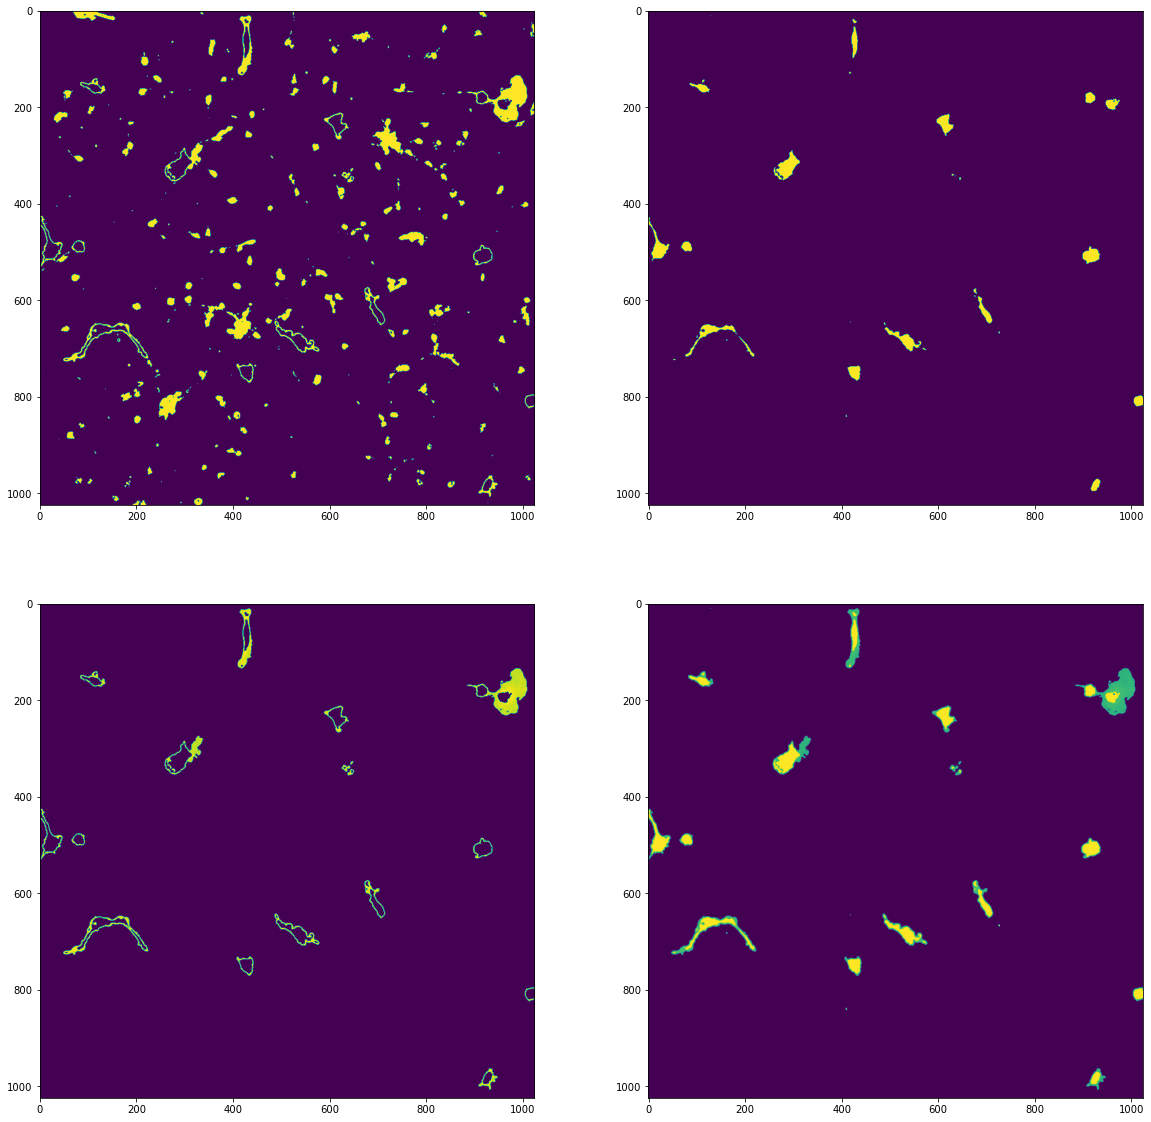

In [652]:
# results of "common-structure" search

blank = np.zeros((1024, 1024))

for idx, p1 in enumerate(p1_nearest):
    (minrow, mincol, maxrow, maxcol) = p1_nearest[idx].bbox
    blank[minrow:maxrow, mincol:maxcol] = p1_nearest[idx].intensity_image

fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)
fig.add_subplot(2, 2, 3)
plt.imshow(blank)
fig.add_subplot(2, 2, 4)
plt.imshow(blank+mask2)

/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_B2_1/B2-Site_0/img_channel002_position000_time000000000_z000.tif
found 11 matches


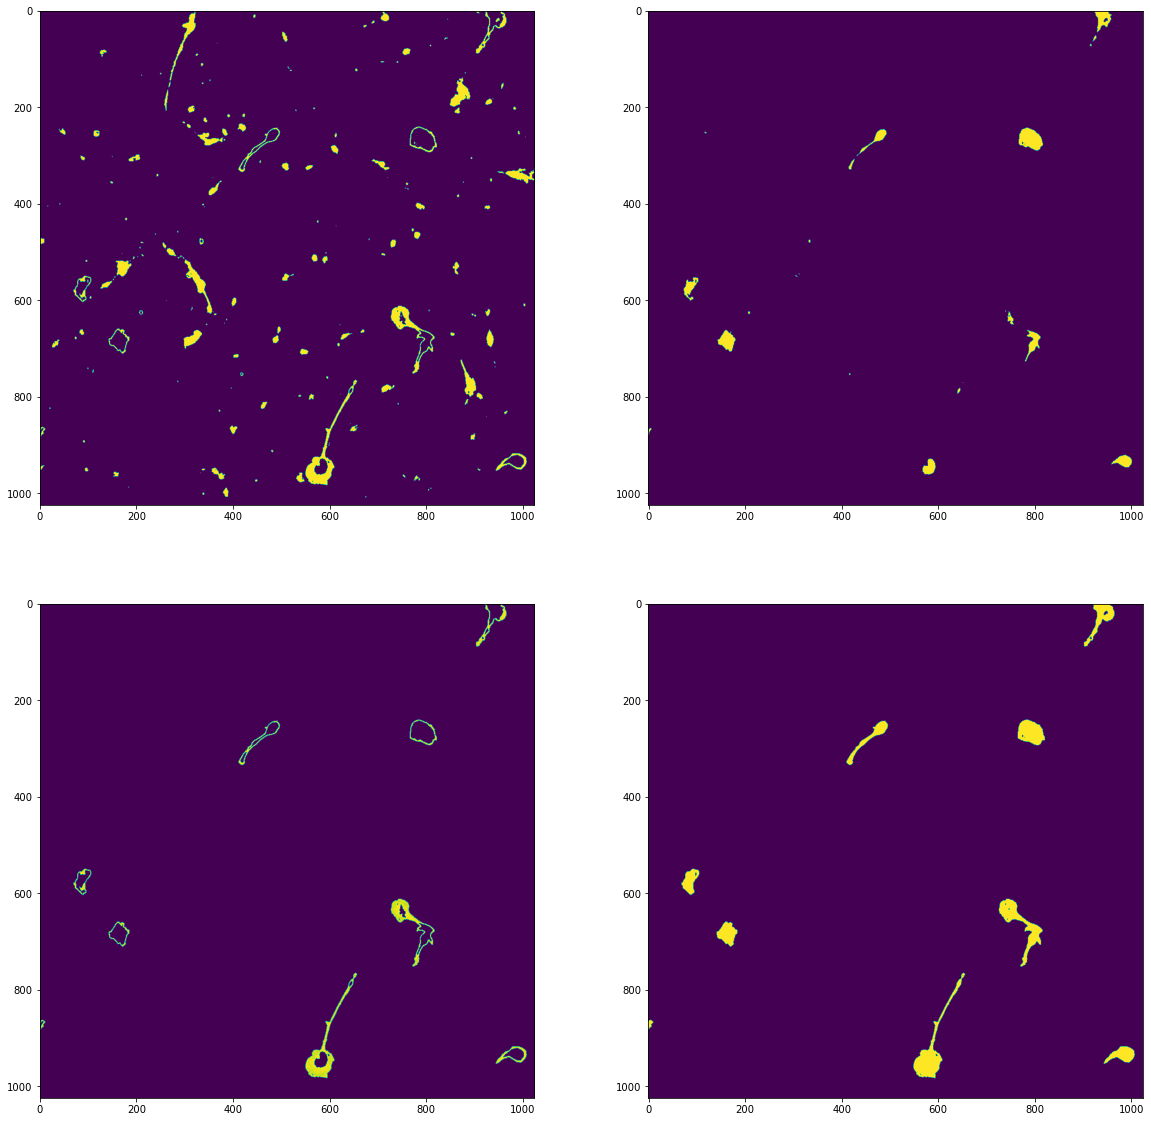

In [666]:
# ======== Try multi otsu on A and B wells =====================

"""
Multi otsu on B Wells
"""

# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_B2_1"
s = 0
site = f"B2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel002 = Iba1-488
print(os.path.join(target, fluor[0]))

# image = tf.imread(os.path.join(target, fluor[0]))

# max intensity projection of whole stack
image_stack = []
for f in sorted(fluor):
    image_stack.append(tf.imread(os.path.join(target, f)))
image_stack = np.stack(image_stack)
image = np.max(image_stack, axis=0)

# ===== PRE FILTERS ========== #
image = exposure.adjust_gamma(image, 0.1)
image = filters.gaussian(image, sigma=1)

# ===== THRESHOLDS =========== #
# == MULTI OTSU ==
thr = threshold_multiotsu(image, classes=3, nbins=512)
im_label = np.digitize(image, bins=thr)
mask0 = im_label == 0
mask1 = im_label == 1
mask2 = im_label == 2

# == generate region props for each structure in mask1 and mask2
from skimage.measure import regionprops, label
label1 = label(mask1)
label2 = label(mask2)
prop1 = regionprops(label1, intensity_image=image)
prop2 = regionprops(label2, intensity_image=image)

# ======= REGION PROP FILTERS =========== 
# filter region props by size
prop1 = filter_area(prop1, 35)
prop2 = filter_area(prop2, 35)

# many
p1_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop1}

# fewer
p2_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop2}


# ======= COMMON STRUCTURE PROPS =========
"""
use centroids as a proxy to determine common structures
"""
region = 30
p1_nearest = []
for p2 in p2_centroids:
    for p1 in p1_centroids:
        if in_range(p1[0], p2[0], region) and in_range(p1[1], p2[1], region):
            p1_nearest.append(p1_centroids[p1])
print(f"found {len(p1_nearest)} matches")
# ========================================

# results of "common-structure" search
blank1 = np.zeros((1024, 1024))
blank2 = np.zeros((1024, 1024))

for idx, p1 in enumerate(p1_nearest):
    (minrow, mincol, maxrow, maxcol) = p1_nearest[idx].bbox
    blank1[minrow:maxrow, mincol:maxcol] = p1_nearest[idx].intensity_image
    
for idx, p2 in enumerate(prop2):
    (minrow, mincol, maxrow, maxcol) = prop2[idx].bbox
    blank2[minrow:maxrow, mincol:maxcol] = prop2[idx].intensity_image

# ========================================
# plotting
fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)

# blank is composed from prop1
fig.add_subplot(2, 2, 3)
plt.imshow(blank1)
# combined is composed from blank1 and blank2
fig.add_subplot(2, 2, 4)
combined = blank1+blank2
combined[combined>0] = 1
plt.imshow(combined)

tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/target_binary/test.tif', combined.astype('uint16'))

found 11 matches


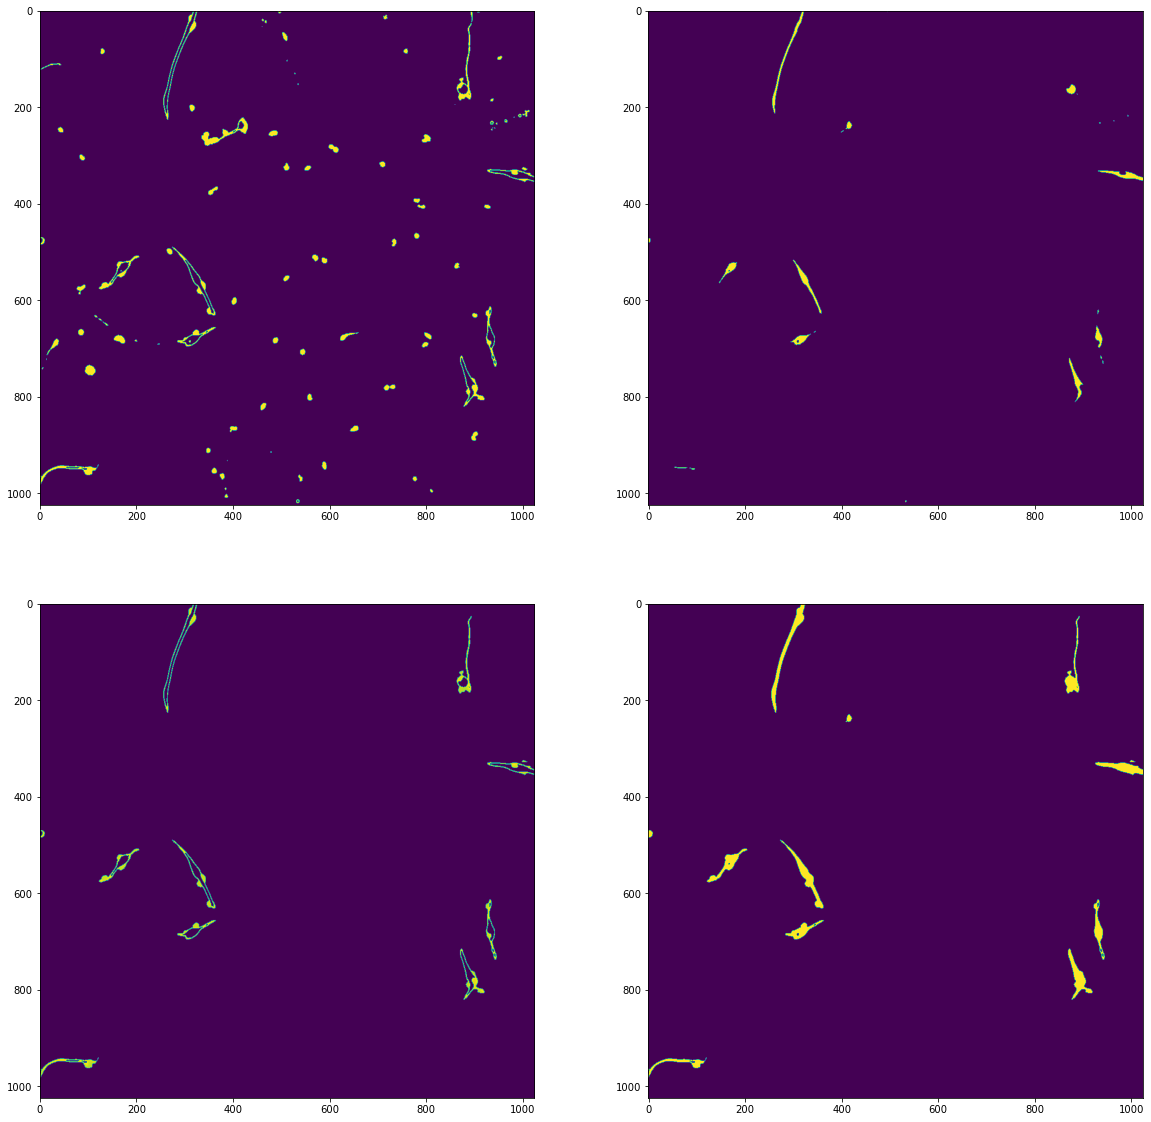

In [78]:
# ======== Try multi otsu on A and B wells =====================

"""
Multi otsu on B Wells
"""

# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_B2_1"
s = 0
site = f"B2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel001" in file]) # channel002 = Iba1-488
# print(os.path.join(target, fluor[0]))

# image = tf.imread(os.path.join(target, fluor[0]))

# max intensity projection of whole stack
image_stack = []
for f in sorted(fluor):
    image_stack.append(tf.imread(os.path.join(target, f)))
image_stack = np.stack(image_stack)
image = np.max(image_stack, axis=0)

# ===== PRE FILTERS ========== #
image = exposure.adjust_gamma(image, 0.1)
image = filters.gaussian(image, sigma=1)

# ===== THRESHOLDS =========== #
# == MULTI OTSU ==
thr = threshold_multiotsu(image, classes=3, nbins=512)
im_label = np.digitize(image, bins=thr)
mask0 = im_label == 0
mask1 = im_label == 1
mask2 = im_label == 2

# == generate region props for each structure in mask1 and mask2
from skimage.measure import regionprops, label
label1 = label(mask1)
label2 = label(mask2)
prop1 = regionprops(label1, intensity_image=image)
prop2 = regionprops(label2, intensity_image=image)

# ======= REGION PROP FILTERS =========== 
# filter region props by size
prop1 = filter_area(prop1, 35)
prop2 = filter_area(prop2, 35)

# many
p1_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop1}

# fewer
p2_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop2}


# ======= COMMON STRUCTURE PROPS =========
"""
use centroids as a proxy to determine common structures
"""
region = 30
p1_nearest = []
for p2 in p2_centroids:
    for p1 in p1_centroids:
        if in_range(p1[0], p2[0], region) and in_range(p1[1], p2[1], region):
            p1_nearest.append(p1_centroids[p1])
print(f"found {len(p1_nearest)} matches")
# ========================================

# results of "common-structure" search
blank1 = np.zeros((1024, 1024))
blank2 = np.zeros((1024, 1024))

for idx, p1 in enumerate(p1_nearest):
    (minrow, mincol, maxrow, maxcol) = p1_nearest[idx].bbox
    blank1[minrow:maxrow, mincol:maxcol] = p1_nearest[idx].intensity_image
    
for idx, p2 in enumerate(prop2):
    (minrow, mincol, maxrow, maxcol) = prop2[idx].bbox
    blank2[minrow:maxrow, mincol:maxcol] = prop2[idx].intensity_image

fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)

# blank is composed from prop1
fig.add_subplot(2, 2, 3)
plt.imshow(blank1)
# combined is composed from blank1 and blank2
fig.add_subplot(2, 2, 4)
combined = blank1+blank2
combined[combined>0] = 1
plt.imshow(combined)

# tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/target_binary/test.tif', combined.astype('uint16'))

In [79]:
tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/Composites/b2-site0_multiotsu_ch1-combined.tif', combined)




/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1/C2-Site_1/img_channel002_position001_time000000000_z000.tif
found 14 matches


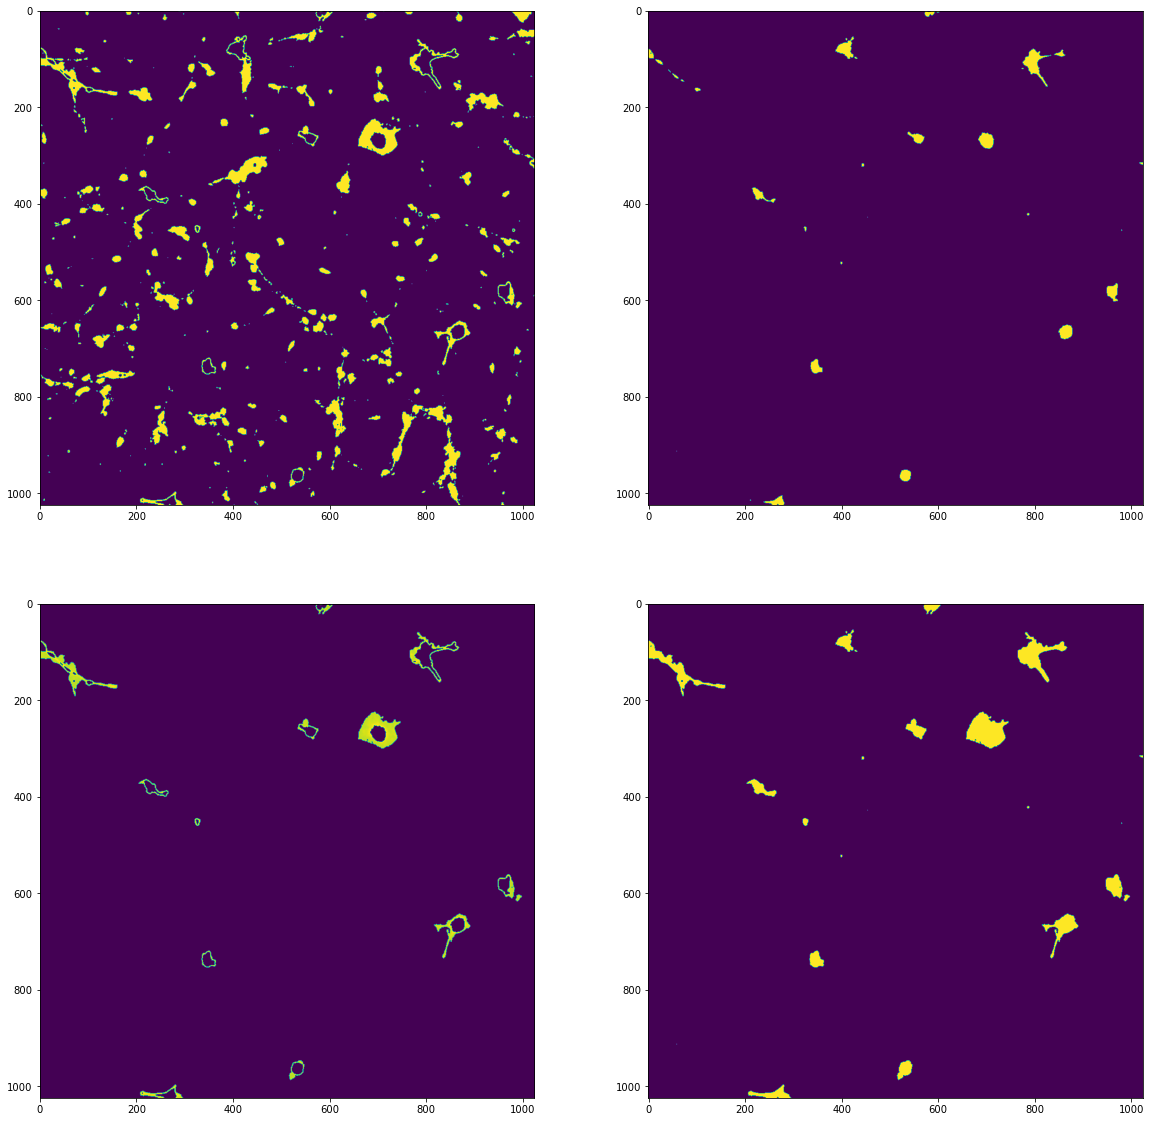

In [89]:
# ======== Try multi otsu on A and B wells =====================

"""
Multi otsu on B Wells
"""

# Try for other well conditions, B2 and C2

projectdir = "/Users/bryant.chhun/Desktop/Data/learningCellState/microglia"

# post-fixed, antibody labeled
sample = "2020-10-29/FLUOR/10222020_MG_MGCoculture-x2_FLUOR_C2_1"
s = 1
site = f"C2-Site_{s}"

# To load DiI stains per site location
target = os.path.join(projectdir, sample)
target = os.path.join(target, site)

# for mm2-gamma files (antibody stained)
fluor = sorted([file for file in os.listdir(target) if "channel002" in file]) # channel002 = Iba1-488
print(os.path.join(target, fluor[0]))

# image = tf.imread(os.path.join(target, fluor[0]))

# max intensity projection of whole stack
image_stack = []
for f in sorted(fluor):
    image_stack.append(tf.imread(os.path.join(target, f)))
image_stack = np.stack(image_stack)
image = np.max(image_stack, axis=0)

# ===== PRE FILTERS ========== #
image = exposure.adjust_gamma(image, 0.1)
image = filters.gaussian(image, sigma=1)

# ===== THRESHOLDS =========== #
# == MULTI OTSU ==
thr = threshold_multiotsu(image, classes=3, nbins=512)
im_label = np.digitize(image, bins=thr)
mask0 = im_label == 0
mask1 = im_label == 1
mask2 = im_label == 2

# == generate region props for each structure in mask1 and mask2
from skimage.measure import regionprops, label
label1 = label(mask1)
label2 = label(mask2)
prop1 = regionprops(label1, intensity_image=image)
prop2 = regionprops(label2, intensity_image=image)

# ======= REGION PROP FILTERS =========== 
# filter region props by size
prop1 = filter_area(prop1, 35)
prop2 = filter_area(prop2, 35)

# many
p1_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop1}

# fewer
p2_centroids = {(int(np.round(p.centroid[0])), int(np.round(p.centroid[1]))): p for p in prop2}


# ======= COMMON STRUCTURE PROPS =========
"""
use centroids as a proxy to determine common structures
"""
region = 30 # pixels between centroids to be considered "same structure"
p1_nearest = []
for p2 in p2_centroids:
    for p1 in p1_centroids:
        if in_range(p1[0], p2[0], region) and in_range(p1[1], p2[1], region):
            p1_nearest.append(p1_centroids[p1])
print(f"found {len(p1_nearest)} matches")
# ========================================

# results of "common-structure" search
blank1 = np.zeros((1024, 1024))
blank2 = np.zeros((1024, 1024))

# blank 1 represents a plot of structures common to mask 1 and mask 2 based on centroid proximity
for idx, p1 in enumerate(p1_nearest):
    (minrow, mincol, maxrow, maxcol) = p1_nearest[idx].bbox
    blank1[minrow:maxrow, mincol:maxcol] = p1_nearest[idx].intensity_image
    
# blank 2 represents a plot of only those regionprops in mask2
for idx, p2 in enumerate(prop2):
    (minrow, mincol, maxrow, maxcol) = prop2[idx].bbox
    blank2[minrow:maxrow, mincol:maxcol] = prop2[idx].intensity_image

fig = plt.figure(figsize=(20,20))
fig.add_subplot(2, 2, 1)
plt.imshow(mask1)
fig.add_subplot(2, 2, 2)
plt.imshow(mask2)

# blank is composed from prop1
fig.add_subplot(2, 2, 3)
plt.imshow(blank1)
# combined is composed from blank1 and blank2
fig.add_subplot(2, 2, 4)
# combined = blank1+blank2
combined = blank1+mask2
combined[combined>0] = 1
plt.imshow(combined)
# plt.imshow(blank2)

# tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/target_binary/test.tif', combined.astype('uint16'))

In [88]:
tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/Composites/c2-site0_multiotsu-combined-ch2.tif', combined)
# tf.imsave('/Users/bryant.chhun/Desktop/Data/learningCellState/microglia/2020-10-29/Composites/b2-site0_multiotsu-class2.tif', mask2)